# Plotting API
AEPsych provdes a set of plotting utility functions that helps you do common plotting 
procedures. These plotting functions are intended to be used closely with the Matplotlib
API and be very similar to Seaborn in form. In this way, you are expected to calculate 
the necessary values (e.g., model predictions), which other utility functions in AEPsych
can help with. The raw values can then be passed to the plotting functions to quickly
produce publication-ready plots when used with Matplotlib's usual object-oriented API.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from aepsych.models import GPClassificationModel, GPRegressionModel
from aepsych.plotting import (
    facet_slices,
    plot_contours,
    plot_points_1d,
    plot_points_2d,
    plot_predict_1d,
    plot_predict_2d,
)
from aepsych.transforms import ParameterTransformedModel, ParameterTransforms
from aepsych.transforms.ops import NormalizeScale
from aepsych.utils import dim_grid
from sklearn.datasets import make_classification, make_regression


c:\open\fbsource\fbcode\frl\ae\aepsych\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we simulate the data for a binary classification task with 3 parameters. Basically, 
the workflow for the new ploting function is that we expect the user to have the raw 
data (which could be obtained directly from a db or just loaded in as a csv) and a model
to fit on the data. 

In the example below, the data is simulated to be in raw parameter space (note the 
disparate scales). So we will need a parameter transform wrapped model to transform the
data into a normalized transformed space. If the data has already been transformed, a 
model without the transform is fine.

In [2]:
lb = torch.tensor([-10, 0, 100])
ub = torch.tensor([-5, 1, 900])
dims = lb.shape[0]
x, y = make_classification(
    n_samples=100,
    n_features=dims,
    n_redundant=0,
    n_informative=3,
    random_state=1,
    n_clusters_per_class=4,
)
x, y = torch.tensor(x), torch.tensor(y)

# Rescale x dimensions to specific bounds, first minmax scale normalize, then rescale with unnormalize with bounds
# All this is just to simulate data in raw parameter space given specific weird scales
_min_max = ParameterTransforms(normalize=NormalizeScale(d=dims))
x = _min_max.transform(x)

normalize = ParameterTransforms(
    normalize=NormalizeScale(d=3, bounds=torch.stack([lb, ub]))
)
x = normalize.untransform(x)

# At this point x is the data in the raw space, the model expects the data to be in
# transformed space, therefore we need a parameter transform wrapped model, initialized
# as below
model = ParameterTransformedModel(
    model=GPClassificationModel, dim=dims, transforms=normalize
)

# Add data to model
model.fit(x, y)


## Basics
We can't easily plot 3D but we can take slices of the space and plot them as 2D 
heatmaps.

In [3]:
# Get prediction grid
grid_size = 30
post_grid = dim_grid(lb, ub, gridsize=grid_size)
posterior = model.posterior(normalize.transform(post_grid))
post_mean = posterior.mean.squeeze().detach()


To plot a slice, we reshape the grid back to the 3D cube and slice that.

C:\Users\jasonchow\AppData\Local\Temp\ipykernel_6212\1022511909.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


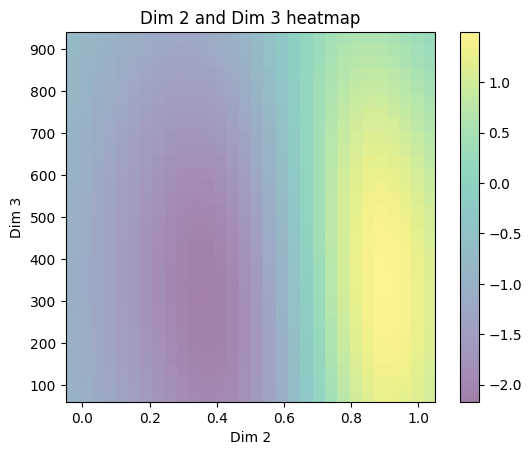

In [ ]:
fig, ax = plt.subplots()

# Plotting 2D
prediction = post_mean.reshape(*[grid_size] * len(lb))
prediction = prediction[0]  # one slice

plotted_ax = plot_predict_2d(
    ax=ax,
    prediction=prediction,
    lb=lb[1:],  # Plotting the last 2 dimensions
    ub=ub[1:],
    edge_multiplier=0.1,  # Extends the borders a bit so we don't have to worry about boundaries
    colorbar=True,
)

# Notice how we can call additional methods on axis to add extra elements
ax.set_title("Dim 2 and Dim 3 heatmap")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 3")

fig.show()


We can add points to the heatmap by sequentially calling the plotting functions. All of 
AEPsych's plotting function plot in place and can be stacked together.

C:\Users\jasonchow\AppData\Local\Temp\ipykernel_6212\3173774818.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


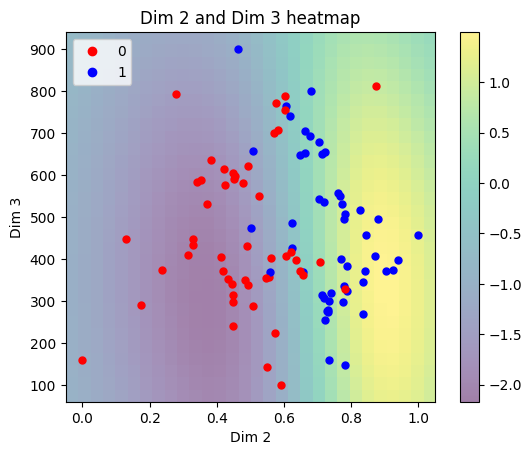

In [ ]:
fig, ax = plt.subplots()

# Plotting 2D
prediction = post_mean.reshape(*[grid_size] * len(lb))
prediction = prediction[0]  # one slice

plotted_ax = plot_predict_2d(
    ax=ax,
    prediction=prediction,
    lb=lb[1:],  # Plotting the last 2 dimensions
    ub=ub[1:],
    edge_multiplier=0.1,  # Extends the borders a bit so we don't have to worry about boundaries
    colorbar=True,
)

plotted_ax = plot_points_2d(
    ax=ax, x=x[:, 1:], y=y, legend_loc="upper left"  # Only the last 2 dimensions
)

ax.set_title("Dim 2 and Dim 3 heatmap")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 3")

fig.show()


We can also add JNDs and use some of the more advanced configuration options to encode
a bit more info in the heatmap for a presentation ready plot. 

C:\Users\jasonchow\AppData\Local\Temp\ipykernel_6212\713086715.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


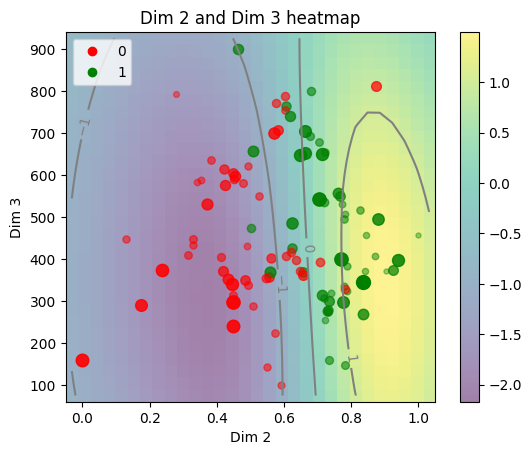

In [ ]:
fig, ax = plt.subplots()

# Plotting 2D
prediction = post_mean.reshape(*[grid_size] * len(lb))
prediction = prediction[0]  # one slice

plotted_ax = plot_predict_2d(
    ax=ax,
    prediction=prediction,
    lb=lb[1:],  # Plotting the last 2 dimensions
    ub=ub[1:],
    edge_multiplier=0.1,  # Extends the borders a bit so we don't have to worry about boundaries
    colorbar=True,
)

# If we provide the plotting function extra information about the slice, we can size the
# points based on how close they are to the slice we're doing.
plotted_ax = plot_points_2d(
    ax=ax,
    x=x,  # Give everything so it can slice and calculate distances
    y=y,
    point_size=10,
    axis=[1, 2],
    slice_vals=torch.tensor([-5]),  # The value of the sliced out dimension
    slice_gradient=1,  # Controls how quickly the size drops off based on distance
    cmap_colors=[
        "r",
        "g",
    ],  # Defining color of dots, r/g is usually bad for colorblind!
    legend_loc="upper left",
)

plotted_ax = plot_contours(
    ax=ax,
    prediction=prediction,
    lb=lb[1:],
    ub=ub[1:],
    levels=torch.tensor(
        [-1, 0, 1]
    ),  # Levels based on the space we're using, so posterior
    edge_multiplier=0.1,
    color="gray",
    labels=True,
)

# Notice how we can call additional methods on axis to add extra elements
ax.set_title("Dim 2 and Dim 3 heatmap")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 3")

fig.show()


# Faceting
Higher dimensional spaces are probably better visualized by facets. We can do that 
using subplots in the usual Matplotlib way.

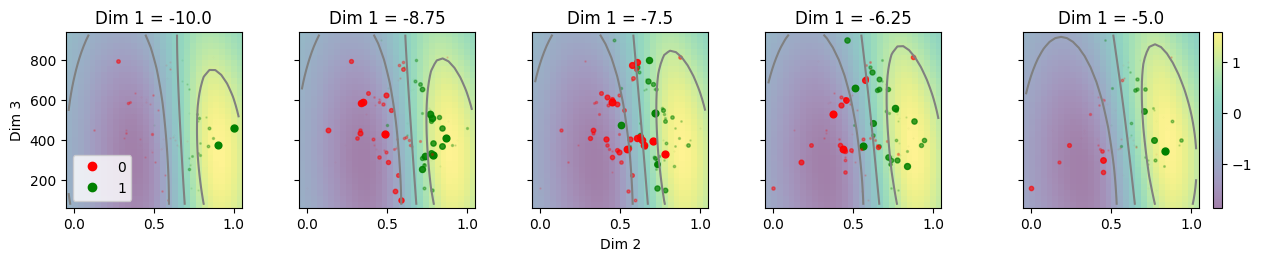

In [ ]:
plotted_axes = [1, 2]
nrows = 1
ncols = 5
prediction = post_mean.reshape(*[grid_size] * len(lb))

fig, axes, slice_vals, slice_pred = facet_slices(
    prediction=prediction,
    plotted_axes=plotted_axes,
    lb=lb,
    ub=ub,
    nrows=nrows,
    ncols=ncols,
    plot_size=2.5,
    sharex=True,
    sharey=True,
)

nPlots = 0
for i in np.ndindex(axes.shape):
    nPlots += 1
    pred = slice_pred[i]
    ax = axes[i]

    plotted_ax = plot_predict_2d(
        ax=ax,
        prediction=pred,
        lb=lb[plotted_axes],  # Plotting the last 2 dimensions
        ub=ub[plotted_axes],
        edge_multiplier=0.1,  # Extends the borders a bit so we don't have to worry about boundaries
        colorbar=nPlots == ncols,
    )

    # If we provide the plotting function extra information about the slice, we can size the
    # points based on how close they are to the slice we're doing.

    plotted_ax = plot_points_2d(
        ax=ax,
        x=x,  # Give everything so it can slice and calculate distances
        y=y,
        point_size=5,
        axis=plotted_axes,
        slice_vals=[slice_vals[i]],  # The value of the sliced out dimension
        slice_gradient=5,  # Controls how quickly the size drops off based on distance
        cmap_colors=[
            "r",
            "g",
        ],  # Defining color of dots, r/g is usually bad for colorblind!
        label_points=nPlots == 1,
        legend_loc="lower left",
    )

    plotted_ax = plot_contours(
        ax=ax,
        prediction=pred,
        lb=lb[plotted_axes],
        ub=ub[plotted_axes],
        levels=torch.tensor(
            [-1, 0, 1]
        ),  # Levels based on the space we're using, so posterior
        edge_multiplier=0.1,
        color="gray",
        labels=False,
    )

    plotted_ax.set_title(f"Dim 1 = {slice_vals[i]}")

    if nPlots == 1:
        plotted_ax.set_ylabel("Dim 3")
    if nPlots == 3:
        plotted_ax.set_xlabel("Dim 2")


# 1D plots

If we want to plot marginal predictions, we would create a evaluation grid based on the
bounds we care about and slice in the raw space. This allows us to get us the marginal
predictions given a specific slice. 1D plots conveniently allow us to visualize the 
uncertainty, to do that, we would need to sample from posterior at each point in the
posterior. This is all done manually now from the model. Notice that because we need to
transform the grid into normalized space, the grid needs to be transformed for the 
posterior.

These procedures (outside of calculating marginal predictions) can be used to plot 1D
spaces as well.

In [8]:
# Get prediction grid for a 1D slice of the space
post_grid_1d = dim_grid(lb, ub, gridsize=grid_size, slice_dims={1: 0.5, 2: 500})
posterior_1d = model.posterior(model.transforms.transform(post_grid_1d))
post_mean_1d = posterior_1d.mean.squeeze().detach()

# Sample from posterior to create upper and lower bands
samples = posterior_1d.sample(torch.Size([1000])).squeeze()
post_lower = torch.quantile(samples, 0.025, dim=0)
post_upper = torch.quantile(samples, 0.975, dim=0)


To plot the data, we can use our plotting function. All of the plotting functions 
require an axes to be made and we will plot directly onto it. This lets us stack 
together different functions from aepsych and to use other matplotlib plotting 
workflows. This includes other packages that use matplotlib as a base like seaborn.

C:\Users\jasonchow\AppData\Local\Temp\ipykernel_6212\4007786291.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


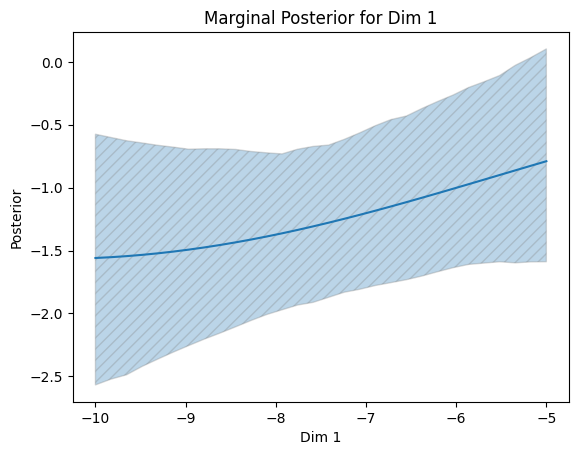

In [9]:
fig, ax = plt.subplots()

# Expected to plot in place, so original figure is modified
plotted_ax = plot_predict_1d(
    ax=ax,
    x=post_grid_1d[:, 0],
    prediction=post_mean_1d,
    pred_lower=post_lower,
    pred_upper=post_upper,
)

plotted_ax.set_title("Marginal Posterior for Dim 1")
plotted_ax.set_xlabel("Dim 1")
plotted_ax.set_ylabel("Posterior")

fig.show()


We can compose together different plotting functions from AEPsych, so we can call the
functions one after another. So we add points this time.

C:\Users\jasonchow\AppData\Local\Temp\ipykernel_6212\2920812949.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


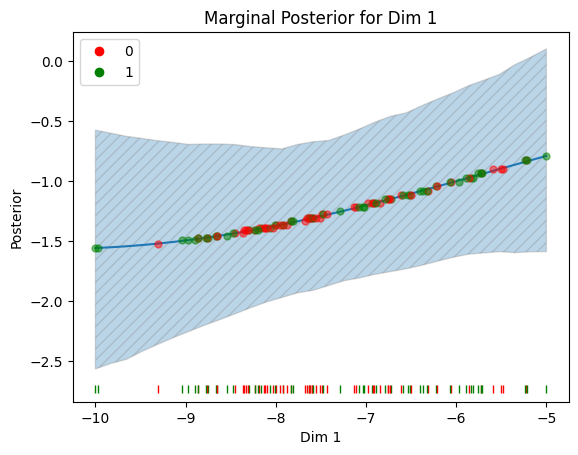

In [10]:
fig, ax = plt.subplots()

# Expected to plot in place, so original figure is modified
plotted_ax = plot_predict_1d(
    ax=ax,
    x=post_grid_1d[:, 0],
    prediction=post_mean_1d,
    pred_lower=post_lower,
    pred_upper=post_upper,
)

# Plots dots on the posterior line
plotted_ax = plot_points_1d(
    ax=ax,
    x=x[:, 0],
    y=y,
    pred_x=post_grid_1d[:, 0],
    pred_y=post_mean_1d,
    point_size=5.0,
    cmap_colors=["r", "g"],
)

# We can remove the prediction args and just plot hatches at the bottom
plotted_ax = plot_points_1d(
    ax=ax,
    x=x[:, 0],
    y=y,
    point_size=5.0,
    cmap_colors=["r", "g"],
)

plotted_ax.set_title("Marginal Posterior for Dim 1")
plotted_ax.set_xlabel("Dim 1")
plotted_ax.set_ylabel("Posterior")

# Notice we don't actually do anything with plotted_ax ever, ax == plotted_ax
# Notice how we can just do both at the same time and both will be added separately.
fig.show()


All AEPsych plotting functions have **kwargs that is passed to the underlying plotting
function, exactly which one is dependent on the function, their docstrings details it.

Below is an example of a complete and customized plot ready for presentation.

C:\Users\jasonchow\AppData\Local\Temp\ipykernel_6212\796139629.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


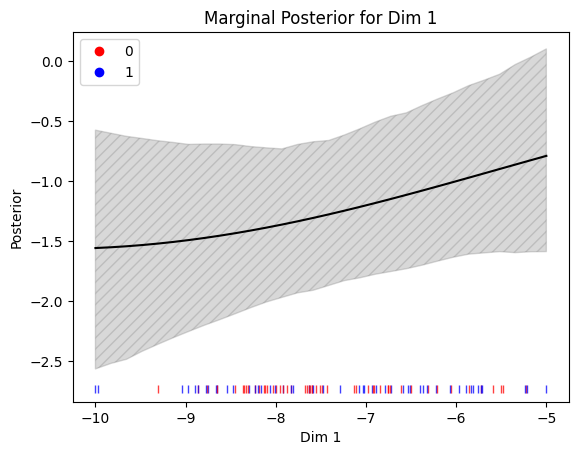

In [11]:
fig, ax = plt.subplots()

# Expected to plot in place, so original figure is modified
plotted_ax = plot_predict_1d(
    ax=ax,
    x=post_grid_1d[:, 0],
    prediction=post_mean_1d,
    pred_lower=post_lower,
    pred_upper=post_upper,
    shaded_kwargs={"color": "gray"},  # Kwargs for the shaded region in a dict
    color="black",  # Extra kwarg for the line
)

# We can remove the prediction args and just plot hatches at the bottom
plotted_ax = plot_points_1d(
    ax=ax,
    x=x[:, 0],
    y=y,
    point_size=5.0,
    cmap_colors=["r", "b"],
    alpha=0.75,  # Extra kwarg for hatche marks at the bottom
)

ax.set_title("Marginal Posterior for Dim 1")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Posterior")

# Notice how we can just do both at the same time and both will be added separately.
fig.show()


# Pairwise plots
All the points plotting function have support for pairwise points adding a line between
pairs of points. These capabilities are activated when the points are formatted in the 
pairwise form `(n, d, 2)`. 

In [ ]:
# We simulate pairwise data by just stacking our simulated data, the pairs won't really
# make sense but it'll work for this tutorial
x_pairwise = torch.concatenate(
    [
        x[0 : x.shape[0] // 2, :].unsqueeze(-1),
        x[x.shape[0] // 2 :, :].unsqueeze(-1),
    ],
    axis=2,
)
x_pairwise_1d = torch.concatenate(
    [
        x[0 : x.shape[0] // 2, 0].unsqueeze(-1).unsqueeze(-1),
        x[x.shape[0] // 2 :, 0].unsqueeze(-1).unsqueeze(-1),
    ],
    axis=2,
)

y_pairwise = y[: y.shape[0] // 2]
x_pairwise.shape


torch.Size([50, 3, 2])

C:\Users\jasonchow\AppData\Local\Temp\ipykernel_6212\2643418602.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


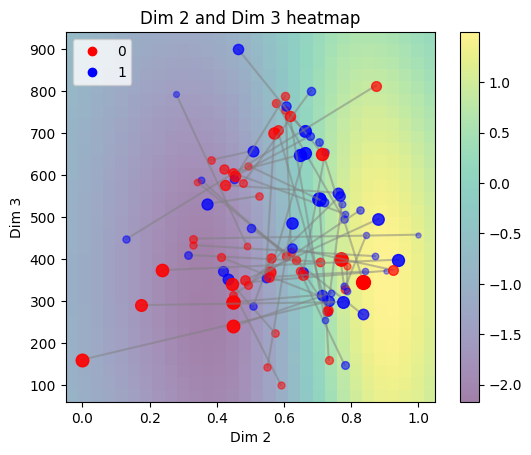

In [13]:
fig, ax = plt.subplots()

# Plotting 2D
prediction = post_mean.reshape(*[grid_size] * len(lb))
prediction = prediction[0]  # one slice

plotted_ax = plot_predict_2d(
    ax=ax,
    prediction=prediction,
    lb=lb[1:],  # Plotting the last 2 dimensions
    ub=ub[1:],
    edge_multiplier=0.1,  # Extends the borders a bit so we don't have to worry about boundaries
    colorbar=True,
)

plotted_ax = plot_points_2d(
    ax=ax,
    x=x_pairwise,
    y=y_pairwise,
    point_size=10,
    axis=[1, 2],
    slice_vals=torch.tensor([-5]),
    slice_gradient=1,
    legend_loc="upper left",
)

ax.set_title("Dim 2 and Dim 3 heatmap")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 3")

fig.show()


C:\Users\jasonchow\AppData\Local\Temp\ipykernel_6212\1859518769.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


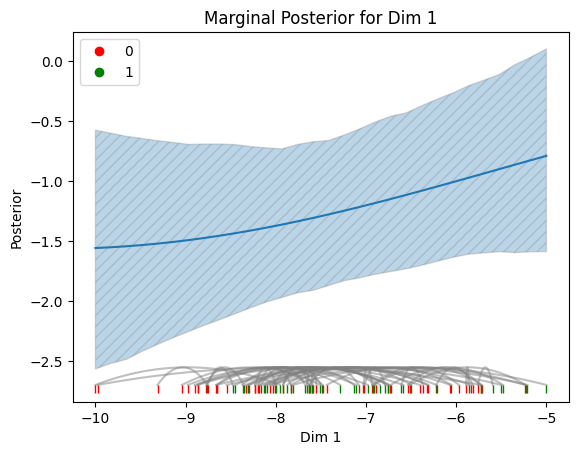

In [14]:
fig, ax = plt.subplots()

# Expected to plot in place, so original figure is modified
plotted_ax = plot_predict_1d(
    ax=ax,
    x=post_grid_1d[:, 0],
    prediction=post_mean_1d,
    pred_lower=post_lower,
    pred_upper=post_upper,
)


# We can remove the prediction args and just plot hatches at the bottom, they also have lines
plotted_ax = plot_points_1d(
    ax=ax,
    x=x_pairwise_1d,
    y=y_pairwise,
    point_size=5.0,
    cmap_colors=["r", "g"],
)

plotted_ax.set_title("Marginal Posterior for Dim 1")
plotted_ax.set_xlabel("Dim 1")
plotted_ax.set_ylabel("Posterior")

fig.show()


## Non-Binary Problems
Both plot_points functions work with non-binary problems. The colors of the points can 
be manipulated via the `cmap_color` args. 

For regression problems, using two colors for `cmap_color` as default will interpolate
the points based on the min and max responses. 

For ordinal problems, it would be best to use a separate color for each discrete element
in `cmap_color`.

In [15]:
dims = 1
lb = torch.zeros(dims)
ub = torch.ones(dims)
x, y = make_regression(
    n_samples=100,
    n_features=dims,
    n_informative=dims,
    random_state=1,
)
x, y = torch.tensor(x), torch.tensor(y)

transform = ParameterTransforms(normalize=NormalizeScale(d=dims))

# Make a model
model = ParameterTransformedModel(
    model=GPRegressionModel, dim=dims, transforms=transform
)

# Add data to model
model.fit(x, y)
# Need to freeze the transforms in place
model.eval()

# Get prediction grid
grid_size = 30
post_grid = transform.untransform(dim_grid(lb, ub, gridsize=grid_size))
posterior = model.posterior(post_grid)
post_mean = posterior.mean.squeeze().detach()


C:\Users\jasonchow\AppData\Local\Temp\ipykernel_6212\322230283.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


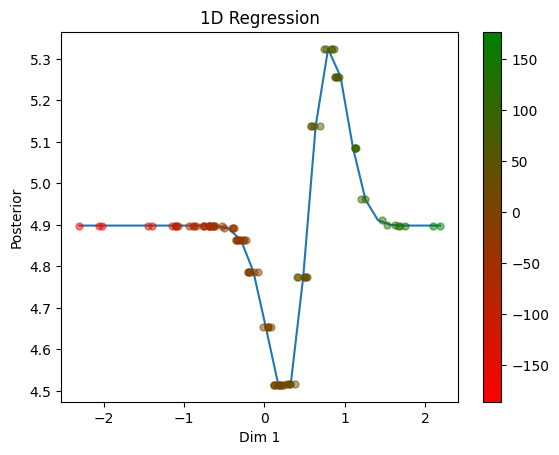

In [16]:
fig, ax = plt.subplots()

# Expected to plot in place, so original figure is modified
plotted_ax = plot_predict_1d(
    ax=ax,
    x=post_grid[:, 0],
    prediction=post_mean,
)

plotted_ax.set_title("1D Regression")
plotted_ax.set_xlabel("Dim 1")
plotted_ax.set_ylabel("Posterior")

plotted_ax = plot_points_1d(
    ax=ax,
    x=x,
    y=y,
    pred_x=post_grid[:, 0],
    pred_y=post_mean,
    point_size=5.0,
    cmap_colors=["r", "g"],
)


fig.show()


## 4D Faceting
Just as it is possible to facet 3D parameter spaces, the faceting helper function can go
be used in 4D.

In [17]:
lb = torch.tensor([-10, 0, 100, 0])
ub = torch.tensor([-5, 1, 900, 1])
dims = lb.shape[0]
x, y = make_classification(
    n_samples=100,
    n_features=dims,
    n_redundant=0,
    n_informative=4,
    random_state=1,
    n_clusters_per_class=4,
)
x, y = torch.tensor(x), torch.tensor(y)

# Rescale x dimensions to specific bounds, first minmax scale normalize, then rescale with unnormalize with bounds
# All this is just to simulate data in raw parameter space given specific weird scales
_min_max = ParameterTransforms(normalize=NormalizeScale(d=dims))
x = _min_max.transform(x)

normalize = ParameterTransforms(
    normalize=NormalizeScale(d=dims, bounds=torch.stack([lb, ub]))
)
x = normalize.untransform(x)

# At this point x is the data in the raw space, the model expects the data to be in
# transformed space, therefore we need a parameter transform wrapped model, initialized
# as below
model = ParameterTransformedModel(
    model=GPClassificationModel, dim=dims, transforms=normalize
)

# Add data to model
model.fit(x, y)

# Get prediction grid

grid_size = 30
post_grid = dim_grid(lb, ub, gridsize=grid_size)
posterior = model.posterior(normalize.transform(post_grid))
post_mean = posterior.mean.squeeze().detach()
prediction = post_mean.reshape(*[grid_size] * len(lb))


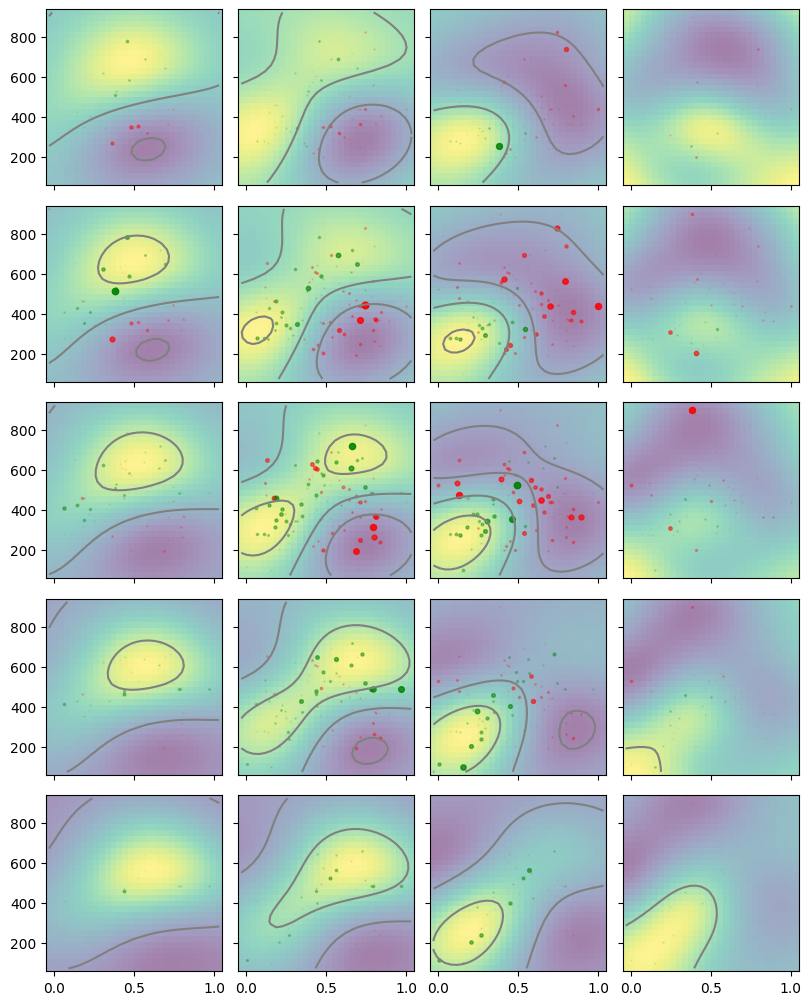

In [18]:
plotted_axes = [1, 2]
nrows = 5
ncols = 4
fig, axes, slice_vals, slice_pred = facet_slices(
    prediction=prediction,
    plotted_axes=plotted_axes,
    lb=lb,
    ub=ub,
    nrows=nrows,
    ncols=ncols,
    plot_size=2,
    sharex=True,
    sharey=True,
)

for i, j in np.ndindex(axes.shape):
    pred = slice_pred[i, j]
    ax = axes[i, j]

    plotted_ax = plot_predict_2d(
        ax=ax,
        prediction=pred,
        lb=lb[plotted_axes],  # Plotting the last 2 dimensions
        ub=ub[plotted_axes],
        edge_multiplier=0.1,  # Extends the borders a bit so we don't have to worry about boundaries
        colorbar=False,
    )

    # If we provide the plotting function extra information about the slice, we can size the
    # points based on how close they are to the slice we're doing.

    plotted_ax = plot_points_2d(
        ax=ax,
        x=x,  # Give everything so it can slice and calculate distances
        y=y,
        point_size=5,
        axis=plotted_axes,
        slice_vals=slice_vals[i, j],  # The value of the sliced out dimension
        slice_gradient=5,  # Controls how quickly the size drops off based on distance
        cmap_colors=[
            "r",
            "g",
        ],  # Defining color of dots, r/g is usually bad for colorblind!
        label_points=False,
    )

    plotted_ax = plot_contours(
        ax=ax,
        prediction=pred,
        lb=lb[plotted_axes],
        ub=ub[plotted_axes],
        levels=torch.tensor(
            [-1, 0, 1]
        ),  # Levels based on the space we're using, so posterior
        edge_multiplier=0.1,
        color="gray",
        labels=False,
    )
